# Demand Forecasting with Transformers

In [14]:
import tensorflow as tf

import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler

from transformer import *
from utils import *

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sns.set()

We test a Transformer architecture for Time-Series forecasting. We use the London bike demand dataset from kaggle:
https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

The goal is to forecast the future bike demand.

The following features are used from the data:

* timestamp
* cnt — the count of new bike shares
* t1 — real temperature in C
* t2 — temperature in C “feels like”
* hum — humidity in percentage
* wind_speed — wind speed in km/h
* weather_code — category of the weather
* is_holiday — 1 holiday / 0 non holiday
* is_weekend — 1 if the day is weekend
* season —: 0-spring ; 1-summer; 2-fall; 3-winter.

In [15]:
df = pd.read_csv(
  "london.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [16]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

### Scale data

In [17]:
train=df.copy()
train_size=int(0.9*len(train))


f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

train=train.values


### Create Trainingdata

In [18]:
window = 50
future=20

BATCH_SIZE = 256
BUFFER_SIZE = 10000

x_train_multi, y_train_multi  = multivariate_data(train, train[:, 0], 0,
                                                train_size, window,
                                                 future, 1)
x_val_multi, y_val_multi = multivariate_data(train, train[:, 0],
                                            train_size, None, window,
                                             future, 1)


train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

print(train_data_multi)
print(val_data_multi)

50 15672
15722 17394
<RepeatDataset shapes: ((None, 50, 13), (None, 20)), types: (tf.float64, tf.float32)>
<RepeatDataset shapes: ((None, 50, 13), (None, 20)), types: (tf.float64, tf.float32)>


### Build Transformer Model

In [19]:
features=train.shape[-1]

d_model=256
maximum_position_encoding=10000


inputs = tf.keras.layers.Input(shape=(window,features))

transformer_block = Encoder(num_layers=2, d_model=d_model, num_heads=2, 
                         dff=256, input_vocab_size=8500,
                         maximum_position_encoding=window)
x = transformer_block(inputs, training=False, mask=None)
x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(future)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')


In [20]:
EVALUATION_INTERVAL=train.shape[0] // BATCH_SIZE
print(EVALUATION_INTERVAL)
EPOCHS = 10

demand_history=model.fit(train_data_multi, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data_multi, validation_steps=50)


68
Epoch 1/10
68/68 [==============================] - 94s 1s/step - loss: 0.5426 - val_loss: 0.3630
Epoch 2/10
68/68 [==============================] - 90s 1s/step - loss: 0.3842 - val_loss: 0.3171
Epoch 3/10
68/68 [==============================] - 92s 1s/step - loss: 0.3524 - val_loss: 0.3160
Epoch 4/10
68/68 [==============================] - 88s 1s/step - loss: 0.3359 - val_loss: 0.3045
Epoch 5/10
68/68 [==============================] - 91s 1s/step - loss: 0.3232 - val_loss: 0.2976
Epoch 6/10
68/68 [==============================] - 92s 1s/step - loss: 0.3120 - val_loss: 0.2841
Epoch 7/10
68/68 [==============================] - 101s 1s/step - loss: 0.3008 - val_loss: 0.2732
Epoch 8/10
68/68 [==============================] - 95s 1s/step - loss: 0.2869 - val_loss: 0.2595
Epoch 9/10
68/68 [==============================] - 94s 1s/step - loss: 0.2687 - val_loss: 0.2464
Epoch 10/10
68/68 [==============================] - 93s 1s/step - loss: 0.2580 - val_loss: 0.2363


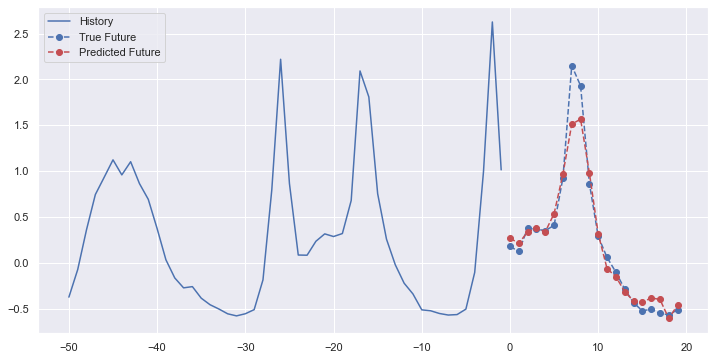

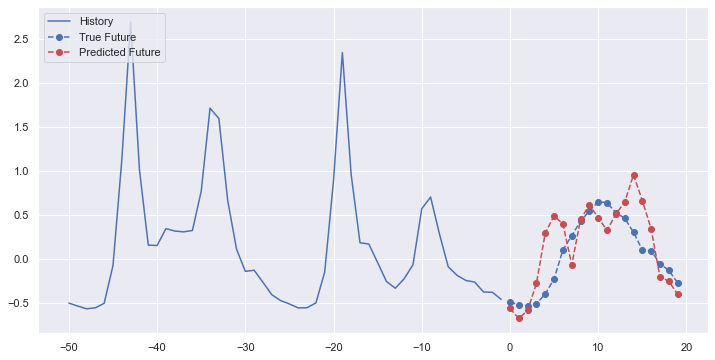

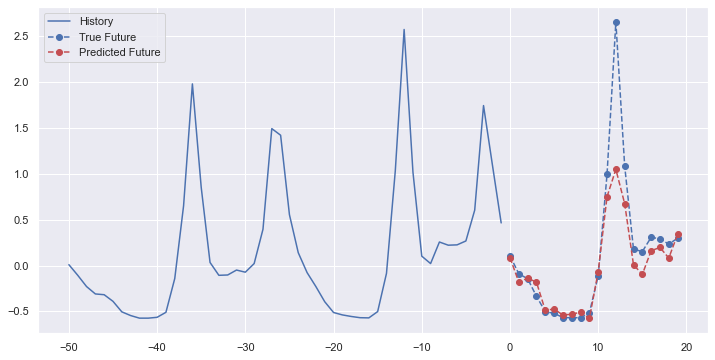

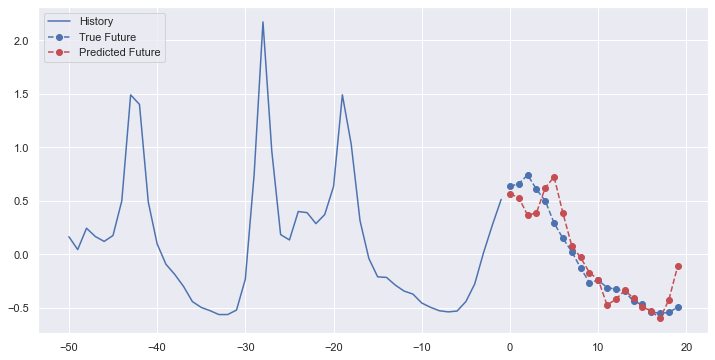

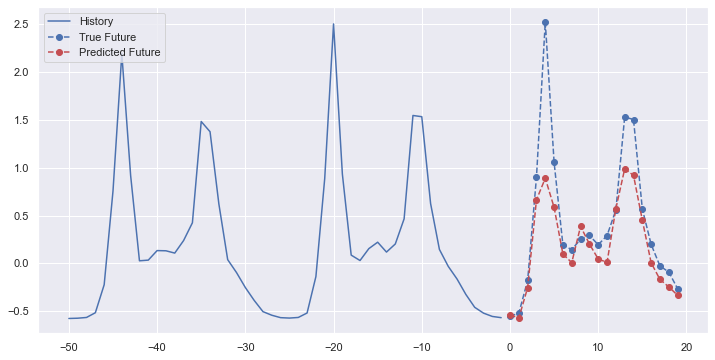

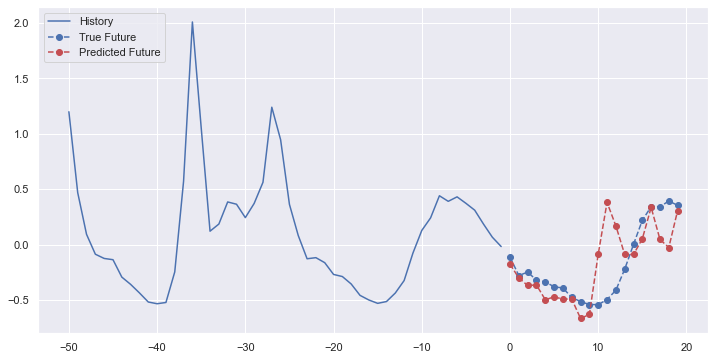

In [22]:
num_val_examples=x_val_multi.shape[0] // BATCH_SIZE
for x, y in val_data_multi.take(num_val_examples):
 #   print(x.shape)
    #for k in range(10):
    k=0
    multi_step_plot(x[k], y[k], model.predict(x)[k])
